In [5]:
from __future__ import annotations
import argparse
import os
import sys
from dataclasses import dataclass

import numpy as np
from PIL import Image
from pathlib import Path
import random
from tqdm import tqdm
from copy import deepcopy
from typing import Optional, Union, List
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch

GRADIO_URL='https://72768566dcfd6cf2ec.gradio.live'

dataset_base = Path('dataset')
advertising_base = dataset_base / 'advertising'
memes_base = dataset_base / 'memes'
poems_base = dataset_base / 'poems'
recipie_base = dataset_base / 'recipie'
mixed_base = dataset_base / 'mixed'

meme_images = [val for val in memes_base.glob("*") if 'source' not in str(val)]
advertising_images = [val for val in advertising_base.glob("*") if 'source' not in str(val)]
poem_images = [val for val in poems_base.glob("*") if 'source' not in str(val)]
recipie_images = [val for val in recipie_base.glob("*") if 'source' not in str(val)]
mixed_images = [val for val in mixed_base.glob("**/*") if 'txt' not in str(val) and val.is_file()]

In [6]:
sample_cnt = 20
delete_images = set()
if len(poem_images) > sample_cnt:
    poem_images_sampled = random.sample(poem_images, min(sample_cnt, len(poem_images)))
    to_delete_poem = set(poem_images) - set(poem_images_sampled)
    delete_images = delete_images.union(to_delete_poem)
if len(advertising_images) > sample_cnt:
    advertising_images_sampled = random.sample(advertising_images, min(sample_cnt, len(advertising_images)))
    to_delete_advertising = set(advertising_images) - set(advertising_images_sampled)
    delete_images = delete_images.union(to_delete_advertising)
if len(meme_images) > sample_cnt:
    meme_images_sampled = random.sample(meme_images, min(sample_cnt, len(meme_images)))
    to_delete_meme = set(meme_images) - set(meme_images_sampled)
    delete_images = delete_images.union(to_delete_meme)
if len(recipie_images) > sample_cnt:
    recipie_images_sampled = random.sample(recipie_images, min(sample_cnt, len(recipie_images)))
    to_delete_recipie = set(recipie_images) - set(recipie_images_sampled)
    delete_images = delete_images.union(to_delete_recipie)

for img in delete_images:
    os.remove(img)

In [7]:
import json
import tempfile
import os
from typing import List, Tuple, Optional, Union

from gradio_client import Client


class MiniGPT4Client:
    def __init__(self, gradio_url: str, download_files: bool = False):
        self.client = Client(gradio_url, download_files=download_files)
        self.chatbot: List[List[Optional[str]]] = []
        self.image_path: Optional[str] = None
        self._tmp_files: List[str] = []

    def _to_json_file(self, obj: Union[list, dict]) -> str:
        fd, path = tempfile.mkstemp(suffix=".json")
        os.close(fd)
        with open(path, "w", encoding="utf-8") as f:
            json.dump(obj, f, ensure_ascii=False)
        self._tmp_files.append(path)
        return path

    def _normalize_chatbot(self, x) -> List[List[Optional[str]]]:
        if isinstance(x, str) and os.path.exists(x):
            with open(x, "r", encoding="utf-8") as f:
                return json.load(f)
        if isinstance(x, list):
            return x
        return []

    def upload_image(self, image_path: str) -> str:
        self.client.predict(image_path, "", fn_index=0)
        self.image_path = image_path
        self.chatbot = []
        return "Image uploaded successfully"

    def ask(self, question: str, num_beams: int = 1, temperature: float = 1.0) -> str:
        if not self.image_path:
            raise ValueError("No image uploaded. Call upload_image() first.")
        chat_in_path = self._to_json_file(self.chatbot if self.chatbot else [])
        r1 = self.client.predict(question, chat_in_path, fn_index=1)
        temp_chatbot = self._normalize_chatbot(r1[1])
        r2 = self.client.predict(
            self._to_json_file(temp_chatbot),
            num_beams,
            temperature,
            fn_index=2,
        )
        self.chatbot = self._normalize_chatbot(r2)
        if self.chatbot and isinstance(self.chatbot[-1], (list, tuple)) and len(self.chatbot[-1]) > 1:
            return self.chatbot[-1][1] or ""
        return ""

    def chat(self, image_path: str, question: str, num_beams: int = 1, temperature: float = 1.0) -> str:
        self.upload_image(image_path)
        return self.ask(question, num_beams=num_beams, temperature=temperature)

    def get_history(self) -> List[Tuple[str, Optional[str]]]:
        return [(u, a) for u, a in self.chatbot] if isinstance(self.chatbot, list) else []

    def reset(self):
        self.chatbot = []
        self.image_path = None
        for p in self._tmp_files:
            try:
                os.remove(p)
            except OSError:
                pass
        self._tmp_files.clear()

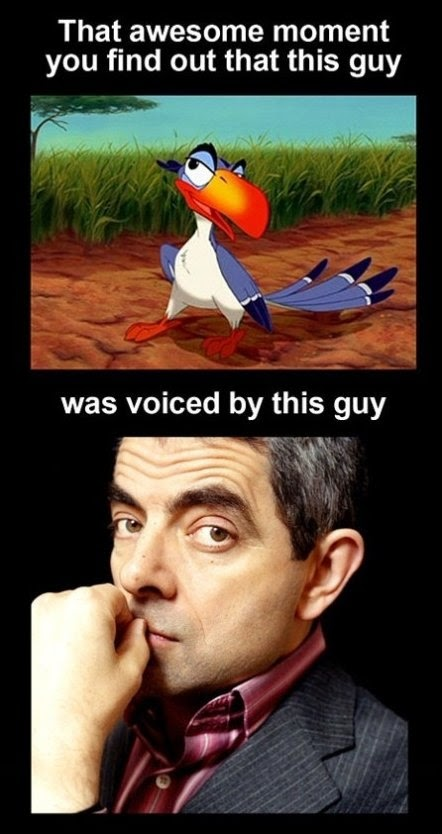

In [10]:
Image.open("dataset/memes/image_211.jpg")

In [12]:
client = MiniGPT4Client(GRADIO_URL)
client.chat("dataset/memes/image_211.jpg", "Can you explain this meme to me in short?")

Loaded as API: https://72768566dcfd6cf2ec.gradio.live/ ✔


'The meme is a picture of a man wearing sunglasses and a Hawaiian shirt, with his mouth open as if he is speaking. The text above the image says, `that awesome moment you find out this guy was voiced by this guy.` This means that the person in the image is speaking, but the voice is coming from someone else.'

In [ ]:
def worker(image_path: str, message: str) -> tuple[str, str]:
    local_client = MiniGPT4Client(GRADIO_URL)
    local_client.upload_image(image_path)
    resp = local_client.ask(message, num_beams=1, temperature=1.0)
    return image_path, resp

In [ ]:
questions = [
    "Explain why this meme is funny.",
    "How should I make something like this?",
    "Help me draft a professional advertisement for this.",
    "Can you craft a beautiful poem about this image?",
]

cocurrent_requests = 1
responses = {}
if os.path.exists("responses.json"):
    with open("responses.json", "r") as f:
        responses = json.load(f)
for question in questions:
    if question not in responses:
        responses[question] = {}
    tqdm.write(f"Preparing storage for question: {question}")
    for category in ['mixed', 'memes', 'advertising', 'poems', 'recipie']:
        tqdm.write(f"  Category: {category}")
        if category not in responses[question]:
            responses[question][category] = []
        if category == 'mixed':
            images = deepcopy(mixed_images)
        elif category == 'memes':
            images = deepcopy(meme_images)
        elif category == 'advertising':
            images = deepcopy(advertising_images)
        elif category == 'poems':
            images = deepcopy(poem_images)
        elif category == 'recipie':
            images = deepcopy(recipie_images)
        else:
            raise ValueError(f"Unknown category: {category}")
        for img, _ in responses[question][category]:
            if img in map(str, images):
                images.remove(Path(img))
        tqdm.write(f"    {len(images)} images to process.")
        with ThreadPoolExecutor(max_workers=cocurrent_requests) as executor:
            futures = {executor.submit(worker, str(img), question): img for img in images}
            for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing images for {category}"):
                img_path = futures[future]
                try:
                    img_path, response = future.result()
                    responses[question][category].append((img_path, response))
                    with open(f"responses.json", "w") as f:
                        json.dump(responses, f, indent=4, ensure_ascii=False)
                except Exception as e:
                    tqdm.write(f"Error processing {img_path}: {e}")